<a href="https://colab.research.google.com/github/WesleyAldridge/HW3_MachineLearning/blob/master/HW3_MachineLearning_Problem2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 2

## Do fine-tuning with data augmentation.

### Retrieving cats_and_dogs data, creating directories

In [20]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip
    
import os
import zipfile
from keras.preprocessing import image
import numpy as np

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

catlist = os.listdir(validation_cats_dir)
doglist = os.listdir(validation_dogs_dir)
print(str(len(catlist) + len(doglist)) + " validation images")

--2019-04-17 22:28:33--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 2607:f8b0:400e:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  42.8MB/s    in 1.5s    

2019-04-17 22:28:35 (42.8 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

1000 validation images


### Loading VGG19

In [0]:
from keras.applications import VGG19

conv_base = VGG19(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

### Freezing convolutional base weights

In [0]:
conv_base.trainable = False

### Creating model with VGG19 convolutional base

In [23]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 22,122,049
Trainable params: 2,097,665
Non-trainable params: 20,024,384
_________________________________________________________________


### Data augmentation

In [24]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Fine-tuning

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

### Running model

In [26]:
from keras import optimizers

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc']
)


history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/30
100/100 [==============================] - 21s 206ms/step - loss: 0.5168 - acc: 0.7350 - val_loss: 0.2916 - val_acc: 0.8740
Epoch 2/30
100/100 [==============================] - 20s 198ms/step - loss: 0.3453 - acc: 0.8370 - val_loss: 0.2323 - val_acc: 0.8970
Epoch 3/30
100/100 [==============================] - 18s 185ms/step - loss: 0.3050 - acc: 0.8680 - val_loss: 0.2546 - val_acc: 0.9010
Epoch 4/30
100/100 [==============================] - 19s 187ms/step - loss: 0.2760 - acc: 0.8835 - val_loss: 0.2933 - val_acc: 0.8980
Epoch 5/30
100/100 [==============================] - 19s 187ms/step - loss: 0.2409 - acc: 0.8945 - val_loss: 0.2155 - val_acc: 0.9130
Epoch 6/30
100/100 [==============================] - 21s 210ms/step - loss: 0.2266 - acc: 0.9085 - val_loss: 0.2571 - val_acc: 0.9090
Epoch 7/30
100/100 [==============================] - 19s 188ms/step - loss: 0.2088 - acc: 0.9135 - val_loss: 0.1969 - val_acc: 0.9230
Epoch 8/30
100/100 [==============================] - 1

### Graphing accuracy

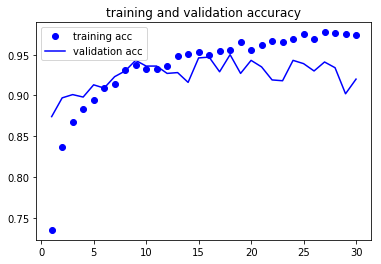

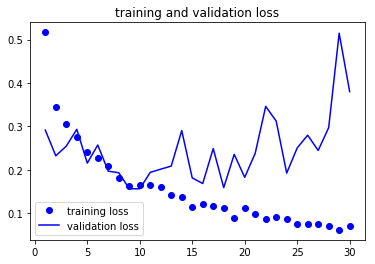

In [27]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

### Print out validation loss and accuracy

In [28]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.3726798423595028
Validation accuracy: 0.9299999952316285


### Save the model

In [0]:
model_fname = 'cats_and_dogs_finetuning.h5' 
model.save(model_fname)

from google.colab import files

with open(model_fname, 'r') as f:
  files.download(model_fname)